In [140]:
import pandas as pd

df = pd.read_csv('semantic.tsv', sep='\t', names=['text', 'is_positive'])
df = df.sample(frac=1).reset_index(drop=True)  # randomize

In [141]:
import re
from nltk.corpus import stopwords
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

stops = set(stopwords.words("english")) | set(stopwords.words("russian"))


def custom_morph(review):
    # 1)
    review_text = re.sub(r"[^а-яА-Яa-zA-Z]", " ", review)
    # 2)
    words = review_text.lower().split()
    # 3)
    words = [w for w in words if not w in stops]
    # 4)
    return ' '.join([morph.parse(w)[0].normal_form for w in words])

df['text_words'] = df.text.map(custom_morph)

In [142]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df.text_words, df.is_positive, test_size=0.2, random_state=10)

In [143]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [144]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=100, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=100, padding='post', truncating='post')

In [145]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [146]:
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Deconv2D
from keras import layers
from keras.models import Sequential

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


model = Sequential()
model.add(Embedding(input_dim=vocab_size,  # кол-во слов в словаре
                    output_dim=30,  # представление слова (виктор из output_dim элементов)
                    input_length=100))  # вход длина массива предложения
# model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

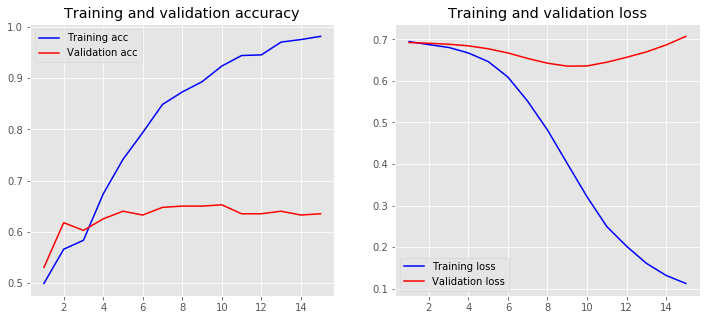

In [147]:
plot_history(model.fit(X_train, y_train, epochs=15, verbose=False, validation_data=(X_test, y_test)))

In [148]:
model.evaluate(X_train, y_train), model.evaluate(X_test, y_test)

400/400 [==============================] - 0s 48us/step


([0.04464386492967606, 1.0], [0.7071970438957215, 0.635])

### With CNN network

In [150]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=35, input_length=100))
model.add(layers.Conv1D(100, 6, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 35)           1241590   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 95, 100)           21100     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 100)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 500)               50500     
_________________________________________________________________
dropout_22 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 501       
Total para

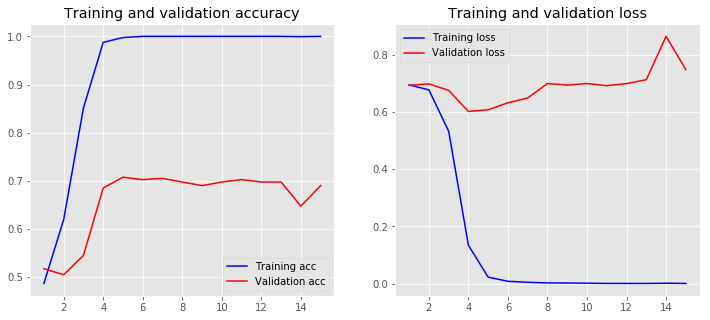

In [151]:
plot_history(model.fit(X_train, y_train, epochs=15, verbose=False, validation_data=[X_test, y_test]))

### Crpss-validation ang get optimized network params

In [169]:
def create_model(conv_num_filters, conv_kernel_size, vocab_size, count_middle_neurons, embedding_dim, sententence_len):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=sententence_len))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(count_middle_neurons, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [171]:
param_grid = dict(conv_num_filters=[55, 65, 75],
                  conv_kernel_size=[2, 3, 4],
                  vocab_size=[vocab_size],
                  embedding_dim=[30, 50],
                  count_middle_neurons=[10, 100, 1000],
                  sententence_len=[sententence_len])

In [160]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

epochs = 20
sententence_len = 100
model = KerasClassifier(build_fn=create_model, epochs=epochs, verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=3, verbose=1, n_iter=3)
grid_result = grid.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.1min finished


In [167]:
# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

print('''
test_accuracy=%s 
best_score=%s
best_params=%s''' % (
    test_accuracy, grid_result.best_score_, grid_result.best_params_
))

"\ntest_accuracy=0.7075 \nbest_score=0.6825\nbest_params={'vocab_size': 35474, 'num_filters': 64, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}"